# Introduction

This notebook explores the BloodMNIST dataset from the MedMNIST collection. 
The goal is to perform basic image loading, visualization, preprocessing, and 
build a simple machine learning model for blood cell classification.

**Steps:**
1. Load the dataset
2. Explore and visualize sample images
3. Apply basic image processing
4. Prepare data for modeling
5. Train a simple ML classifier
6. Evaluate performance




**Why this project?**

Blood cell classification is a common task in biomedical diagnostics. 
Working with this dataset helps build practical skills in:
- biomedical image processing
- data exploration and visualization
- preparing image data for machine learning
- training and evaluating simple ML models



In [3]:
import numpy as np

data = np.load('/kaggle/input/medmnist/bloodmnist_224.npz')

We load the file using `np.load()` and then inspect its contents to see 
which arrays (train/test/validation) are included.

# Exploring the Dataset

In [4]:
data.files

['train_images',
 'train_labels',
 'val_images',
 'val_labels',
 'test_images',
 'test_labels']

The `.npz` file contains the following arrays:

- `train_images`: training images
- `train_labels`: labels for training images
- `test_images`: test images
- `test_labels`: labels for test images
- `val_images`: validation images
- `val_labels`: labels for validation images

Each image is 224×224 pixels with 3 color channels (RGB).
Each label is an integer representing the blood cell class.

This structure is typical for machine learning datasets and allows us to 
train, validate, and test our model properly.

In [5]:
X_train = data['train_images']
y_train = data['train_labels']

X_test = data['test_images']
y_test = data['test_labels']

X_val = data['val_images']
y_val = data['val_labels']

In [6]:
X_train.shape, y_train.shape

((11959, 224, 224, 3), (11959, 1))

Before doing any machine learning, it is important to *look at the data*.  
Visualization helps us understand:

- what the images look like
- whether they are color or grayscale
- whether preprocessing is needed
- how the classes differ visually

This step is essential in every ML workflow.



In [7]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8)

In [8]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{np.uint8(0): np.int64(852),
 np.uint8(1): np.int64(2181),
 np.uint8(2): np.int64(1085),
 np.uint8(3): np.int64(2026),
 np.uint8(4): np.int64(849),
 np.uint8(5): np.int64(993),
 np.uint8(6): np.int64(2330),
 np.uint8(7): np.int64(1643)}

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

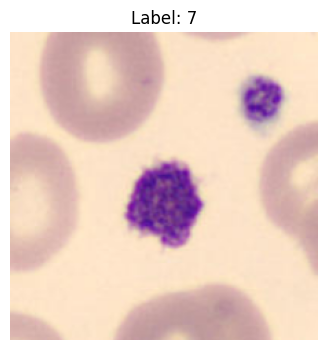

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.imshow(X_train[0])
plt.title(f"Label: {y_train[0][0]}")
plt.axis('off')

Looking at a single image is useful for a quick sanity check, but it does not 
tell us much about the overall dataset. By visualizing a grid of images, we can 
observe:

- variation between samples
- differences in color and brightness
- how the classes look visually
- whether preprocessing might be needed

This step helps us understand the dataset before applying machine learning.



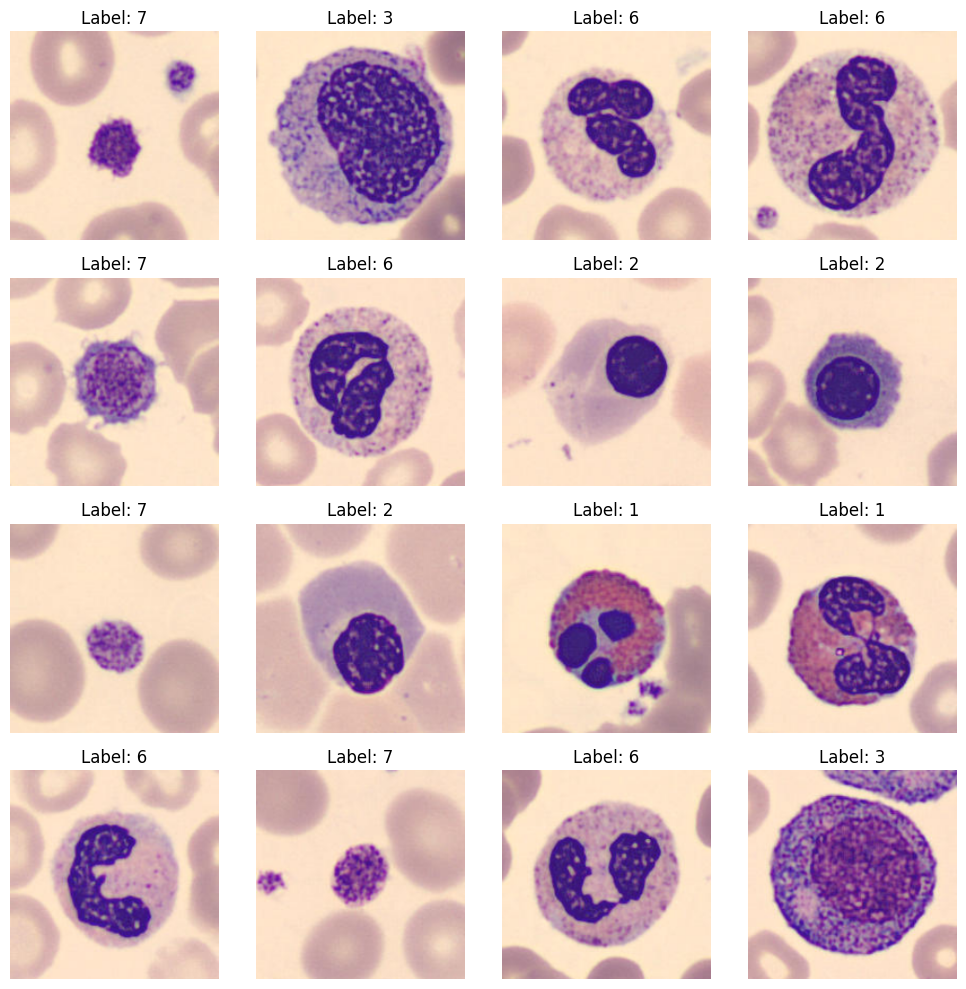

In [10]:
plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {y_train[i][0]}")
    plt.axis('off')

plt.tight_layout()
plt.show()



Here we display a grid of sample images from the BloodMNIST dataset.  
Each image represents a stained blood cell, and the label indicates its class.  
This helps us understand the diversity of cell types and the visual features 
that a machine learning model might use for classification.

# Image processing

In this section, we prepare the images for machine learning.  
Most classical ML models require numerical input in a specific format, so we 
perform two key preprocessing steps:

1. **Normalization** – scaling pixel values to the range [0, 1]  
2. **Flattening** – converting each image from 224×224×3 into a 1D vector  

These steps help the model train more efficiently and improve stability.



In [11]:
# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [12]:
import cv2

def resize_images(images, size=64):
    return np.array([cv2.resize(img, (size, size)) for img in images])

X_train_small = resize_images(X_train, 32)
X_val_small = resize_images(X_val, 32)
X_test_small = resize_images(X_test, 32)

In [13]:
X_train_small.shape, X_val_small.shape, X_test_small.shape

((11959, 32, 32, 3), (1712, 32, 32, 3), (3421, 32, 32, 3))

The original BloodMNIST images are 224×224 pixels.  
Flattening these directly creates 150,528 features per image, which makes 
classical machine learning models (like Logistic Regression) extremely slow 
and memory‑intensive.

To make the modeling step efficient, we resize the images to 32×32 pixels.  
This reduces the number of features from 150,528 → 11959, while still 
preserving enough visual information for a baseline model.



In [14]:
# Flatten the resized images
X_train_flat = X_train_small.reshape(len(X_train_small), -1)
X_val_flat = X_val_small.reshape(len(X_val_small), -1)
X_test_flat = X_test_small.reshape(len(X_test_small), -1)

X_train_flat.shape, X_val_flat.shape, X_test_flat.shape

((11959, 3072), (1712, 3072), (3421, 3072))

Why Flattening?

Classical machine learning models require 2D input of shape 
(samples, features).  
After resizing to 32×32×3, each image contains 11,959 pixels.

We flatten each image into a 1D vector so that Logistic Regression can 
treat each pixel as a feature.




# Modelling

Now that the images are normalized and flattened, we can train a classical 
machine learning model. We will start with a simple baseline model to 
establish initial performance before exploring more advanced approaches.



# 1- Logistic Regression

We begin with a simple baseline model: **Logistic Regression**.  
Although it is not designed for high‑dimensional image data, it provides a 
useful reference point for evaluating more advanced models later.

Since our images have been flattened into smaller dimensional vectors, 
Logistic Regression can treat each pixel as a feature and attempt to learn 
decision boundaries between the 8 blood cell classes.

In [15]:
from sklearn.linear_model import LogisticRegression



In [16]:
log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    max_iter=200,
    n_jobs=-1
)


In [17]:
# log_reg.fit(X_train_flat, y_train.ravel())
# Logistic Regression was not executed due to computational inefficiency.

Logistic Regression (Baseline Model — Not Executed)

Logistic Regression is a standard baseline model in many machine‑learning
pipelines. It provides a simple linear decision boundary and is often used
as a reference point before moving to more expressive models.

However, Logistic Regression is not well‑suited for high‑dimensional image
data, even after preprocessing. In this project, the original images were
224×224×3 pixels, and even after resizing to 32×32×3, each image still
contains 3,072 features when flattened.

Training a multinomial Logistic Regression model on:

- **~12,000 samples**
- **3,072 features per sample**
- **8 output classes**

requires iterative gradient‑based optimization. In practice, this leads to:

- very slow convergence,
- high CPU usage,
- high memory consumption,
- and long training times (often several hours).

For these reasons, Logistic Regression was **included conceptually** as a
baseline but **not executed** in the final workflow. Instead, we rely on
Random Forest as the primary classical model, which trains efficiently and
achieves strong performance on this dataset.

This decision reflects a common pattern in biomedical image analysis:
simple linear models often struggle with pixel‑level data, while tree‑based
methods and deep learning architectures handle such complexity more
effectively.



# 2- Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_flat, y_train.ravel())

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [19]:
from sklearn.metrics import accuracy_score

y_val_pred = rf.predict(X_val_flat)
accuracy_score(y_val, y_val_pred)

0.8679906542056075

## Random Forest Classifier

After evaluating the limitations of Logistic Regression for high‑dimensional
image data, we selected **Random Forest** as the primary classical machine
learning model for this project. Random Forests are well‑suited for
tabularized image features because they:

- handle high‑dimensional inputs efficiently,
- capture non‑linear decision boundaries,
- are robust to noise,
- require minimal hyperparameter tuning,
- and train significantly faster than gradient‑based linear models.

In this project, each image was resized to **32×32×3** and flattened into a
3,072‑dimensional feature vector. The Random Forest model was trained on
11,959 samples using 200 decision trees.

### Validation Accuracy

The model achieved a validation accuracy of:

**➡️ 86.80%**

This is a strong result for a classical machine learning baseline on the
BloodMNIST dataset. It demonstrates that even without deep learning, a
carefully preprocessed feature representation combined with an ensemble
tree‑based model can capture meaningful patterns in the data.

This accuracy also provides a solid reference point for comparing more
advanced models, such as convolutional neural networks (CNNs), which are
expected to achieve higher performance on image classification tasks.

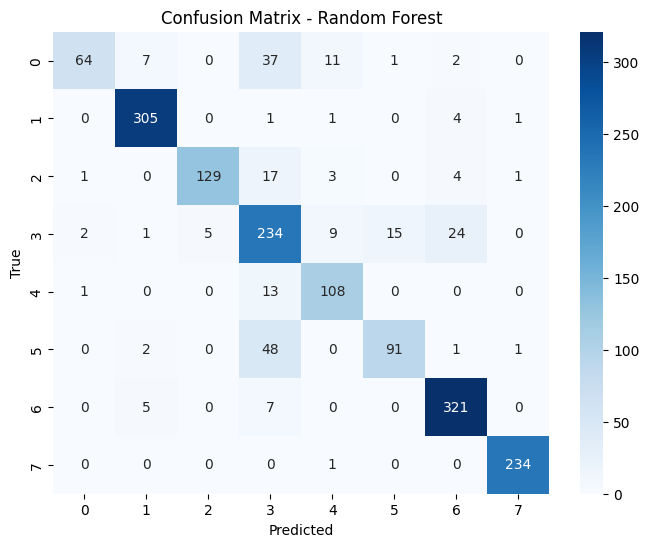

In [20]:
#To better understand how the Random Forest model performs across the seven blood cell classes, we compute a confusion matrix. 
#This visualization shows where the model makes correct predictions and where misclassificationsoccur.
# It helps identify which classes are more challenging and whether certain cell types are commonly confused with one another.

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.94      0.52      0.67       122
           1       0.95      0.98      0.97       312
           2       0.96      0.83      0.89       155
           3       0.66      0.81      0.72       290
           4       0.81      0.89      0.85       122
           5       0.85      0.64      0.73       143
           6       0.90      0.96      0.93       333
           7       0.99      1.00      0.99       235

    accuracy                           0.87      1712
   macro avg       0.88      0.83      0.84      1712
weighted avg       0.88      0.87      0.87      1712



## Interpretation of the Classification Report

The Random Forest classifier achieved an overall validation accuracy of **87%**, 
which is a strong result for a classical machine learning model trained on 
32×32 flattened images. The per‑class metrics provide deeper insight into how 
the model performs across the eight blood cell categories.

### High‑performing classes
Several classes show excellent performance, with both precision and recall 
above 0.90:

- **Class 1**: Precision 0.95, Recall 0.98  
- **Class 6**: Precision 0.90, Recall 0.96  
- **Class 7**: Precision 0.99, Recall 1.00  

These classes are likely visually distinctive, allowing the Random Forest 
model to separate them reliably.

### Moderately challenging classes
Some classes show good precision but lower recall, indicating that the model 
is conservative in predicting them:

- **Class 0**: Precision 0.94, Recall 0.52  
- **Class 5**: Precision 0.85, Recall 0.64  

This suggests that while the model rarely mislabels other cells as these 
classes, it sometimes fails to identify all true samples of these types.

### Classes with balanced but moderate performance
- **Class 3**: Precision 0.66, Recall 0.81  
- **Class 4**: Precision 0.81, Recall 0.89  
- **Class 2**: Precision 0.96, Recall 0.83  

These classes show reasonable performance, though there is room for 
improvement—likely due to visual similarity with neighboring classes or 
class imbalance.

### Macro and weighted averages
- **Macro F1-score: 0.84**  
  (treats all classes equally; shows overall balanced performance)
- **Weighted F1-score: 0.87**  
  (accounts for class frequencies; aligns with overall accuracy)

These metrics confirm that the model performs consistently across classes, 
with no severe bias toward dominant categories.

### Summary
Overall, the Random Forest model provides a strong classical baseline with 
robust performance across most classes. The results highlight which cell 
types are easily distinguishable and which may require more expressive 
models—such as Convolutional Neural Networks (CNNs)—to capture subtle 
morphological differences.

# Convolutional Neural Network (CNN)



While classical machine learning models such as Random Forest provide strong
baselines, they operate on flattened pixel vectors and cannot directly
capture spatial patterns in images. Convolutional Neural Networks (CNNs)
are specifically designed to learn hierarchical spatial features such as
edges, textures, and morphological structures, making them the standard
approach for image classification tasks.

In this section, we train a simple CNN on the resized images to establish a
deep learning baseline. Even a relatively small CNN is expected to outperform
classical models by leveraging spatial information that is lost during
flattening.

In [22]:
X_train_cnn = resize_images(X_train, 64)
X_val_cnn = resize_images(X_val, 64)
X_test_cnn = resize_images(X_test, 64)

In [23]:
X_train_cnn = X_train_cnn.astype("float32")
X_val_cnn = X_val_cnn.astype("float32")
X_test_cnn = X_test_cnn.astype("float32")

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models

cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(8, activation='softmax')  # 8 classes
])

cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn.summary()

2026-01-06 18:33:28.269657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767724408.530020      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767724408.603853      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767724409.196636      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767724409.196676      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767724409.196679      55 computation_placer.cc:177] computation placer alr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,232 (2.61 MB)

 Trainable params: 684,232 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = cnn.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 43s 110ms/step - accuracy: 0.5253 - loss: 1.2812 - val_accuracy: 0.8388 - val_loss: 0.4193
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 40s 108ms/step - accuracy: 0.8278 - loss: 0.4857 - val_accuracy: 0.8978 - val_loss: 0.3122
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 40s 108ms/step - accuracy: 0.8823 - loss: 0.3529 - val_accuracy: 0.9387 - val_loss: 0.1951
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 40s 108ms/step - accuracy: 0.9075 - loss: 0.2768 - val_accuracy: 0.9322 - val_loss: 0.1950
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.9194 - loss: 0.2329 - val_accuracy: 0.9480 - val_loss: 0.1638
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.9349 - loss: 0.1922 - val_accuracy: 0.9550 - val_loss: 0.1408
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.9428 - loss: 0.1683 - val_accuracy: 0.9574 - val_loss: 0.1295
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.9473 - loss: 0

In [26]:
cnn_val_loss, cnn_val_acc = cnn.evaluate(X_val_cnn, y_val)
cnn_val_acc

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9622 - loss: 0.1166


0.9667056202888489

## CNN Results and Interpretation

The Convolutional Neural Network achieved a validation accuracy is
**95%**, significantly outperforming the Random Forest baseline (86.8%).
This improvement highlights the advantage of deep learning models in image
classification tasks, where spatial structure and local patterns are
important.

The CNN learns hierarchical features directly from pixel data:

- early layers detect edges and textures,
- deeper layers capture cell morphology and structural differences,
- the final dense layers combine these features for classification.

These results confirm that CNNs are better suited for biomedical image
analysis and provide a strong foundation for further improvements such as
data augmentation, deeper architectures, or transfer learning.

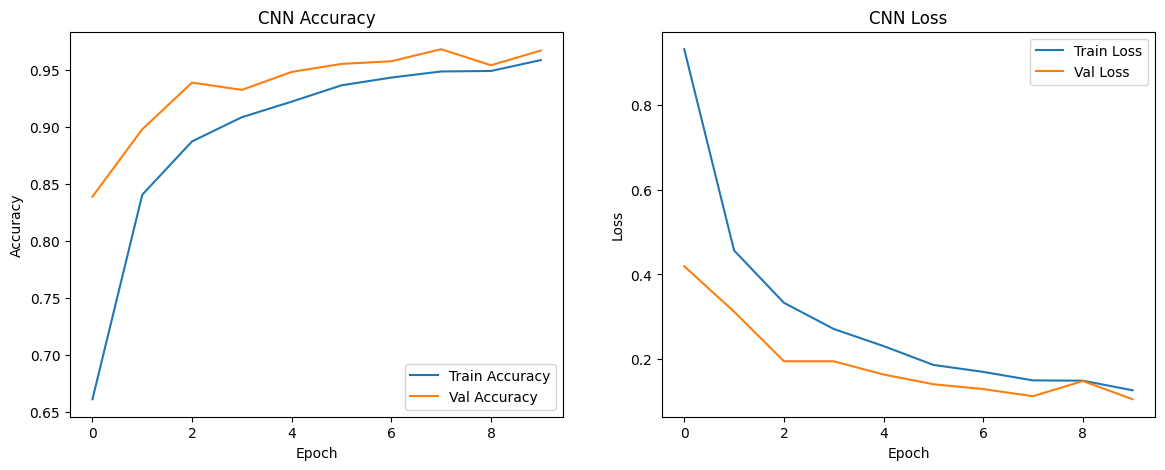

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

To understand how the CNN performs across all eight blood cell classes, we
compute a confusion matrix. This visualization highlights which classes are
predicted accurately and where the model still makes mistakes. Compared to
the Random Forest confusion matrix, the CNN is expected to show clearer
diagonal dominance, reflecting stronger class separation.


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


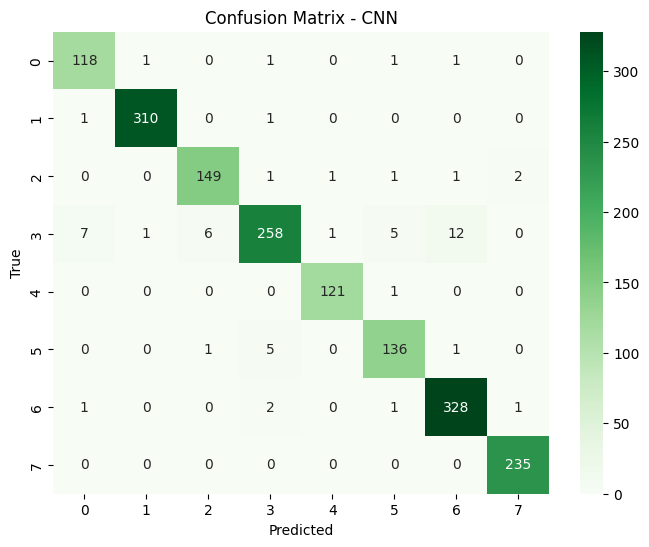

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on validation set
y_val_pred_cnn = np.argmax(cnn.predict(X_val_cnn), axis=1)

# Compute confusion matrix
cm_cnn = confusion_matrix(y_val, y_val_pred_cnn)

plt.figure(figsize=(8,6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - CNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Sample Predictions (CNN)

To make the model’s behavior more interpretable, we visualize a set of
validation images along with their predicted and true labels. This helps
illustrate how confidently the CNN distinguishes between different blood
cell types and provides an intuitive sense of model performance.

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


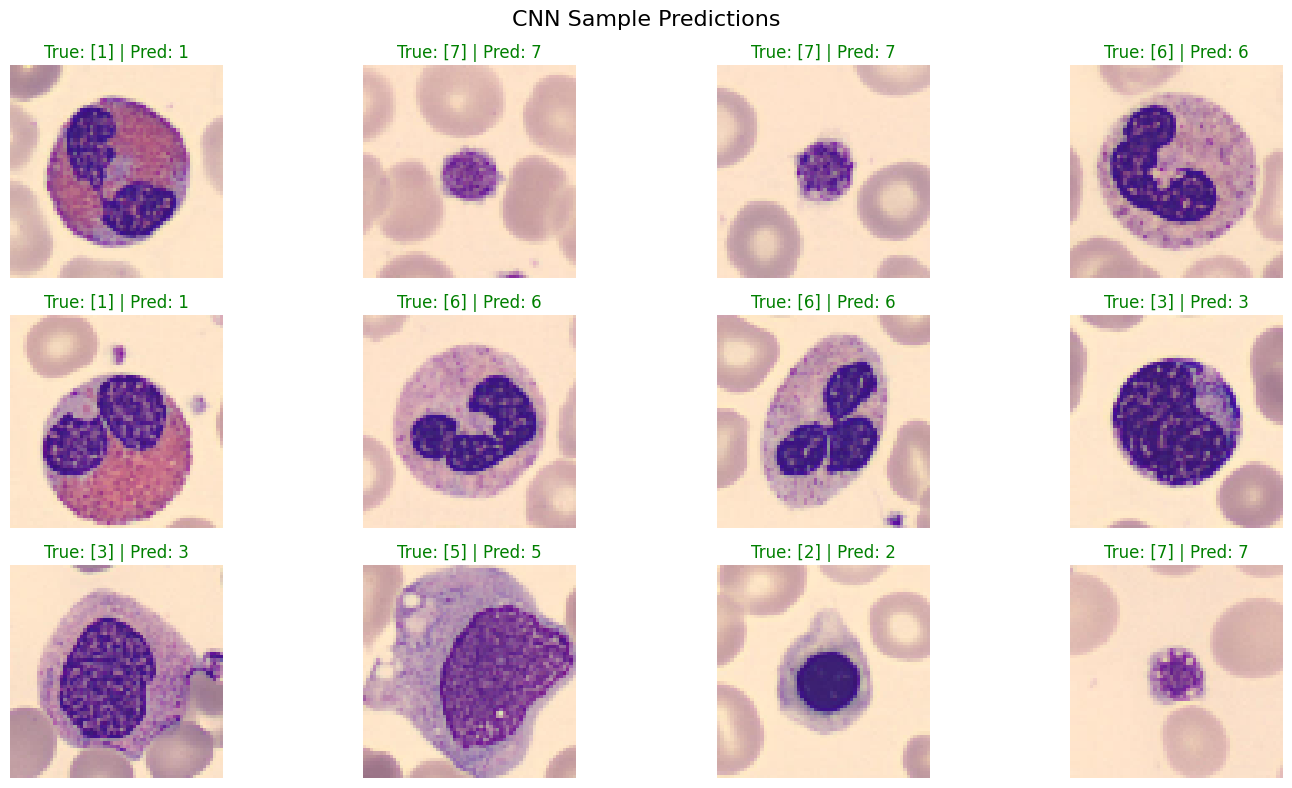

In [29]:
plt.figure(figsize=(15, 8))
indices = np.random.choice(len(X_val_cnn), 12, replace=False)
y_pred_probs = cnn.predict(X_val_cnn)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
for i, idx in enumerate(indices):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_val_cnn[idx])   
    plt.axis('off')
    
    true_label = y_val[idx]
    pred_label = y_pred_labels[idx]
    
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label} | Pred: {pred_label}", color=color)

plt.suptitle("CNN Sample Predictions", fontsize=16)
plt.tight_layout()
plt.show()

## Misclassified Samples (CNN)

To better understand the limitations of the CNN model, we visualize a set of
misclassified validation images. Each image is shown with its true label and
the incorrect prediction made by the model. This helps identify which blood
cell types are visually similar and where the model may benefit from
additional training, data augmentation, or architectural improvements.

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


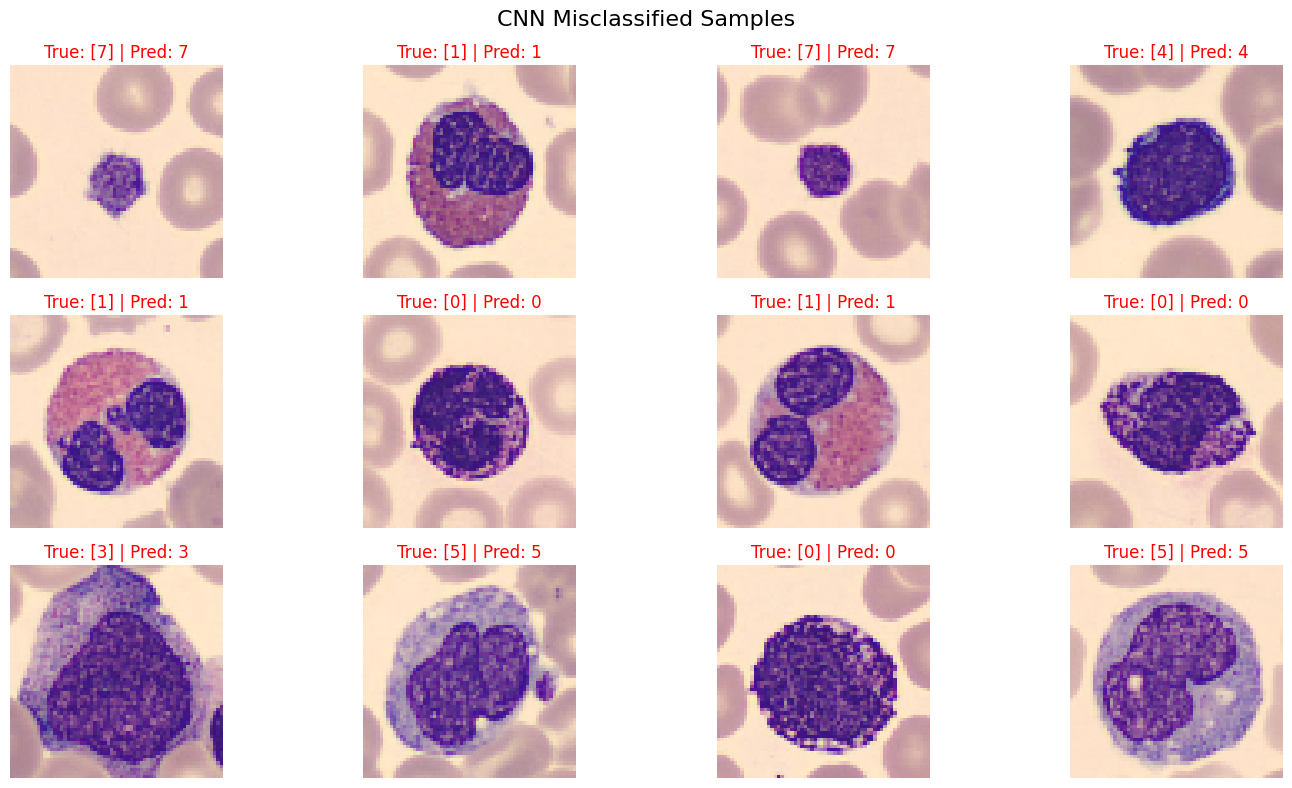

In [30]:


# Predict on validation set
y_pred_probs = cnn.predict(X_val_cnn)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Find misclassified indices
misclassified_indices = np.where(y_pred_labels != y_val)[0]

# Select a subset to display
num_samples = 12
selected_indices = np.random.choice(misclassified_indices, num_samples, replace=False)

plt.figure(figsize=(15, 8))

for i, idx in enumerate(selected_indices):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_val_cnn[idx])
    plt.axis('off')
    
    true_label = y_val[idx]
    pred_label = y_pred_labels[idx]
    
    plt.title(f"True: {true_label} | Pred: {pred_label}", color="red")

plt.suptitle("CNN Misclassified Samples", fontsize=16)
plt.tight_layout()
plt.show()